<a href="https://colab.research.google.com/github/mi622/EDP/blob/main/METODO_GALERKIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<span style="color:brown;">**Método de Galerkin**</span>
<span style="color:blue;"></span>

#<span style="color:orange;">*Problema 5.12 *</span>
<span style="color:blue;"></span>

Se va resolver el problema de frontera

$$
-u''(x) + u(x) - x = 0,\qquad u(0)=0,\quad u(1)=0,
$$

usando el método de Galerkin con tres funciones base

$$
\phi_i(x) = \sin(i\pi x), \quad i=1,2,3.
$$

Primero se obtiene la solución analítica con sympy. Después se construye la
aproximación $(u_3(x))$ con Galerkin, se comparan ambas gráficas y se calcula
el error numérico de la aproximación.

*Librerías y Solución Analítica*

In [27]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
x = sp.symbols('x') # introducimos una variable
u = sp.Function('u') # esto es una función

In [29]:

# -u'' + u - x = 0
ode = -sp.diff(u(x), x, 2) + u(x) - x

# Condiciones de frontera: u(0)=0, u(1)=0
sol_ex = sp.dsolve(ode, ics={u(0): 0, u(1): 0})

print("Solución analítica u(x):")
sp.pprint(sol_ex)

u_ex_expr = sol_ex.rhs          # expresión simbólica
u_ex = sp.lambdify(x, u_ex_expr, "numpy")   # versión numérica


Solución analítica u(x):
               x         -x 
            ℯ⋅ℯ       ℯ⋅ℯ   
u(x) = x - ─────── + ───────
                 2         2
           -1 + ℯ    -1 + ℯ 


#<span style="color:purple;">**Galerkin: funciones base y residuo**</span>
<span style="color:blue;"></span>



In [30]:
# ---- Aproximación por Galerkin ----
# u3(x) = a1*phi1 + a2*phi2 + a3*phi3
# phi_i(x) = sin(i*pi*x)

a1, a2, a3 = sp.symbols('a1 a2 a3')

phi1 = sp.sin(sp.pi * x)
phi2 = sp.sin(2*sp.pi * x)
phi3 = sp.sin(3*sp.pi * x)

u3 = a1*phi1 + a2*phi2 + a3*phi3

# Residuo de la ecuación
R = -sp.diff(u3, x, 2) + u3 - x
sp.simplify(R)

a1*sin(pi*x) + a2*sin(2*pi*x) + a3*sin(3*pi*x) - x + pi**2*(a1*sin(pi*x) + 4*a2*sin(2*pi*x) + 9*a3*sin(3*pi*x))

*Ecuaciones de Galerkin y coeficientes*

In [31]:
# Condiciones de Galerkin:
# ∫_0^1 R(x)*phi_j(x) dx = 0  para j = 1,2,3

I1 = sp.integrate(R*phi1, (x, 0, 1))
I2 = sp.integrate(R*phi2, (x, 0, 1))
I3 = sp.integrate(R*phi3, (x, 0, 1))

sol_a = sp.solve(
    [sp.Eq(I1, 0), sp.Eq(I2, 0), sp.Eq(I3, 0)],
    (a1, a2, a3)
)

print("Coeficientes de Galerkin (a1, a2, a3):")
sol_a

Coeficientes de Galerkin (a1, a2, a3):


{a1: 2/(pi + pi**3), a2: -1/(pi + 4*pi**3), a3: 2/(3*pi + 27*pi**3)}

*Aproximación final $u_3(x)$ y función numérica*

In [32]:
# Sustituimos los coeficientes en u3(x)

u3_expr = sp.simplify(u3.subs(sol_a))
print("u3(x) aproximada por Galerkin:")
sp.pprint(u3_expr)

u3_num = sp.lambdify(x, u3_expr, "numpy")   # versión numérica

u3(x) aproximada por Galerkin:
2⋅sin(π⋅x)   sin(2⋅π⋅x)   2⋅sin(3⋅π⋅x)
────────── - ────────── + ────────────
       3             3              3 
  π + π       π + 4⋅π     3⋅π + 27⋅π  


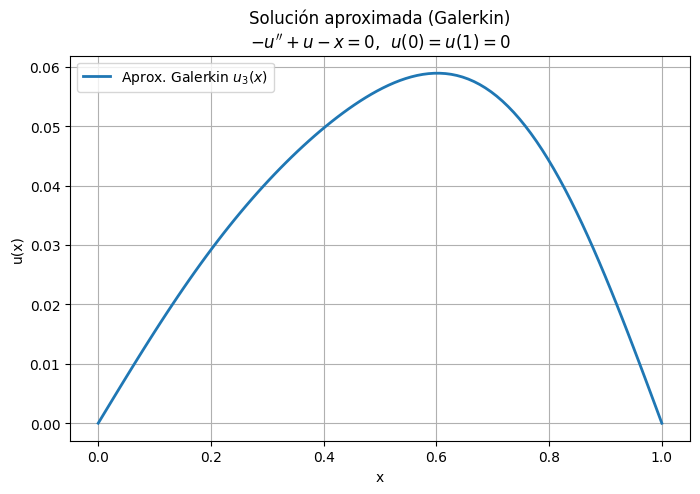

In [34]:

# Convertimos en un arreglo de numpy
# u_expr = sol.rhs  # This line caused the error
# u_num = sp.lambdify(x, u_expr, "numpy") # This line caused the error

#################
xx = np.linspace(0, 1, 100)
yy = u3_num(xx) # Use the pre-computed numerical Galerkin approximation

plt.figure(figsize=(8,5))
plt.plot(xx, yy, label="Aprox. Galerkin $u_3(x)$", linewidth=2)
plt.title("Solución aproximada (Galerkin)\n$-u'' + u - x = 0$,  $u(0)=u(1)=0$")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.legend()
plt.show()

*Gráfica: Analítica VS Galerkin*

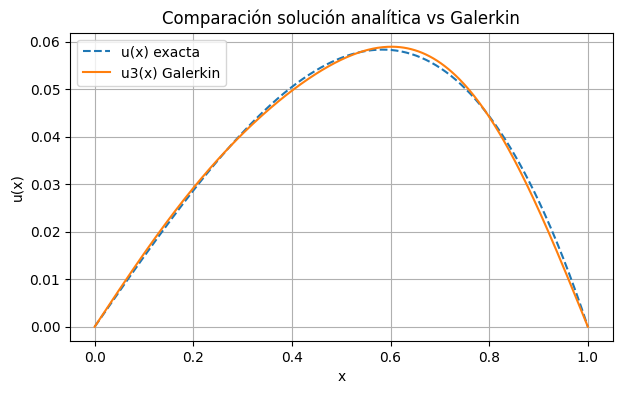

In [35]:
# Comparación gráfica: solución exacta vs Galerkin
xx = np.linspace(0, 1, 400)
yy_ex = u_ex(xx)

yy_gal = u3_num(xx)

plt.figure(figsize=(7, 4))
plt.plot(xx, yy_ex, "--", label="u(x) exacta")
plt.plot(xx, yy_gal, label="u3(x) Galerkin")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparación solución analítica vs Galerkin")
plt.grid(True)
plt.legend()
plt.show()

*Tabla de Errores*

In [36]:
# Tabla de errores en [0,1]

puntos = np.array([0.0, 0.25, 0.50, 0.75, 1.0])

tabla = {
    "x": puntos,
    "u_exacta(x)": u_ex(puntos),
    "u_Galerkin(x)": u3_num(puntos)
}

df_err2 = pd.DataFrame(tabla)
df_err2["|error|"] = np.abs(df_err2["u_exacta(x)"] - df_err2["u_Galerkin(x)"])
df_err2

,x,u_exacta(x),u_Galerkin(x),|error|
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.25,3.504760e-02,3.522118e-02,1.735810e-04
2,0.50,5.659056e-02,5.620640e-02,3.841569e-04
3,0.75,5.027579e-02,5.094857e-02,6.727834e-04
4,1.00,1.387779e-16,9.966594e-18,1.288113e-16


# Conclusiones :

En este ejercicio se utilizó el método de Galerkin con tres funciones base senoidales para obtener una aproximación a la solución del problema de frontera. Al comparar la solución analítica con la aproximación numérica, se observa que ambas curvas siguen prácticamente la misma forma en todo el intervalo [0,1]. Esto indica que el método logra capturar bien el comportamiento general de la solución.

Los valores de la tabla muestran que el error en los puntos evaluados es pequeño y consistente. Además, el cálculo del error máximo confirma que la diferencia entre la solución exacta y la aproximación de Galerkin es muy reducida. En conjunto, estos resultados muestran que el método ofrece una aproximación adecuada usando solo tres funciones base.